In [1]:
import cv2
import numpy
from matplotlib import pyplot as plt
from scipy import ndimage

In [2]:
%matplotlib notebook

In [3]:
img = cv2.imread('../images/dmg-cpu-c_rom.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

<IPython.core.display.Javascript object>


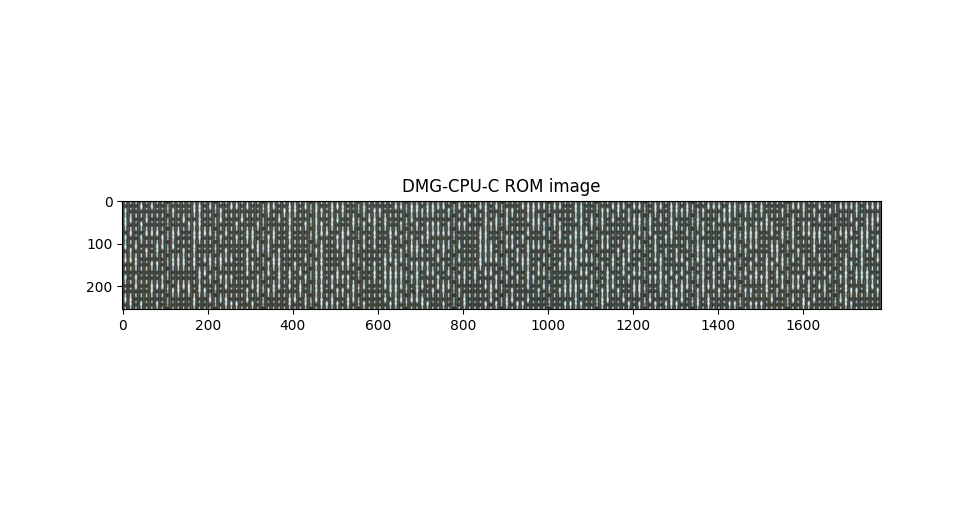

In [4]:
plt.figure()
plt.imshow(img)
plt.title('DMG-CPU-C ROM image')
plt.show()

<IPython.core.display.Javascript object>


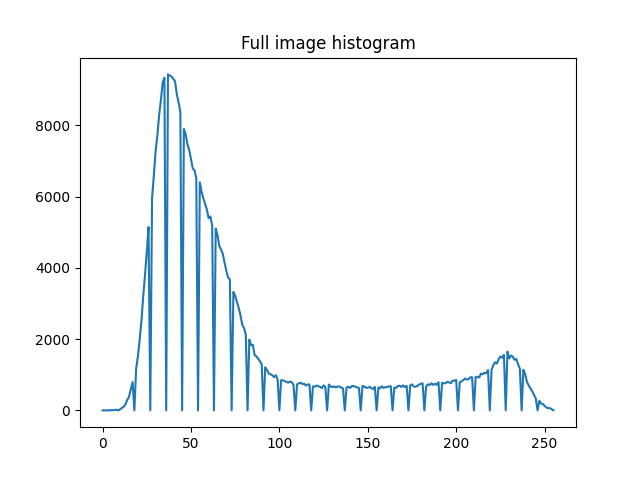

In [5]:
# Histogram
hist, bin_edges = numpy.histogram(img_gray, bins=256)

plt.figure()
plt.plot(hist)
plt.title('Full image histogram')
plt.show()

In [6]:
# Calculate the threshold value for converting the image to binary

# Split pixels into two clusters using k-means
kmeans_input = numpy.asarray(img_gray, numpy.float32).reshape((-1,1))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
_, _, centers = cv2.kmeans(kmeans_input, 2, None, criteria, 10, flags)

# Use the mid-point between the cluster centers as the threshold value
threshold = int((centers[0]+centers[1])/2)

<IPython.core.display.Javascript object>


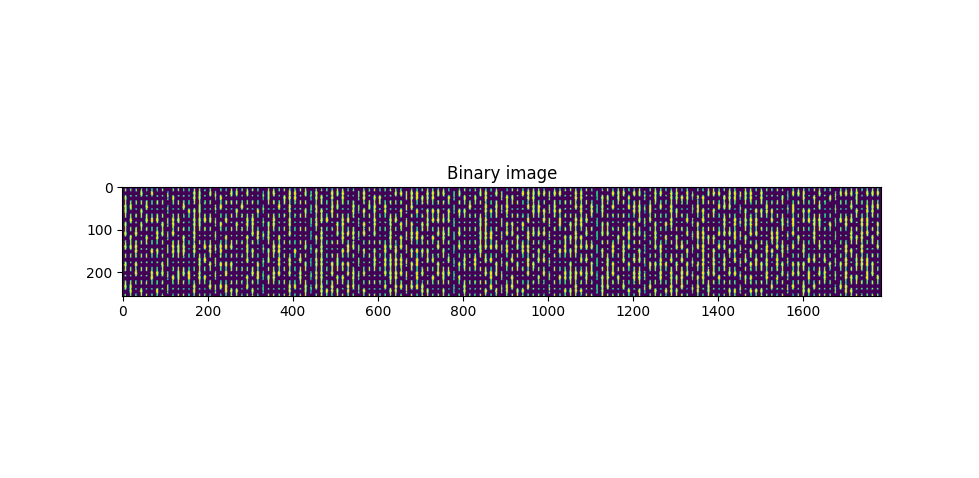

In [7]:
# Create a binary image from the grayscale image, using the threshold value
# we just calculated
_, img_binary = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY)

plt.figure()
plt.imshow(img_binary)
plt.title('Binary image')
plt.show()

<IPython.core.display.Javascript object>


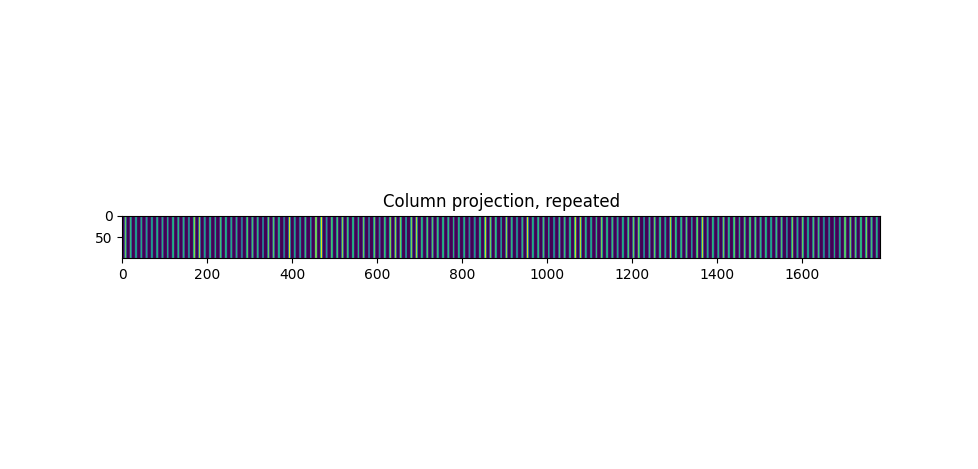

In [8]:
# Create a column projection of the binary image
col_proj = numpy.sum(img_binary, axis=0)

# Tile the column projection for easier visualization
repeated_cols = numpy.tile(col_proj, (100,1))

plt.figure()
plt.imshow(repeated_cols)
plt.title('Column projection, repeated')
plt.show()

In [9]:
# We want to keep the main structures seen in the image above, but filter out
# noise in between before we continue
filtered_cols = numpy.copy(col_proj)
filtered_cols[col_proj<numpy.mean(col_proj)] = 0

# Use segmentation to find all "interesting" columns 
col_labels, col_num_features = ndimage.label(filtered_cols)
col_label_slices = ndimage.find_objects(col_labels)

# Center of mass is more robust to noise than just calculating midpoints
col_label_com = numpy.array(
    [int(s.start + ndimage.measurements.center_of_mass(filtered_cols[s.start:s.stop])[0])
    for col_label_slice in col_label_slices for s in col_label_slice])

<IPython.core.display.Javascript object>


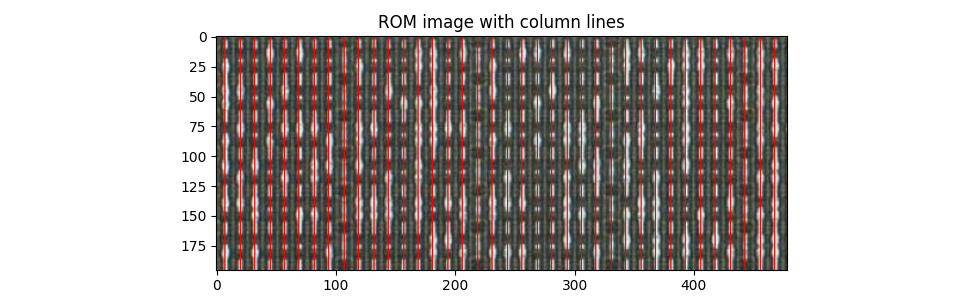

In [10]:
img_col_lines = numpy.copy(img)
img_col_lines[:,col_label_com] = (255,0,0)

plt.figure()
plt.imshow(img_col_lines)
plt.title('ROM image with column lines')
plt.show()

<IPython.core.display.Javascript object>


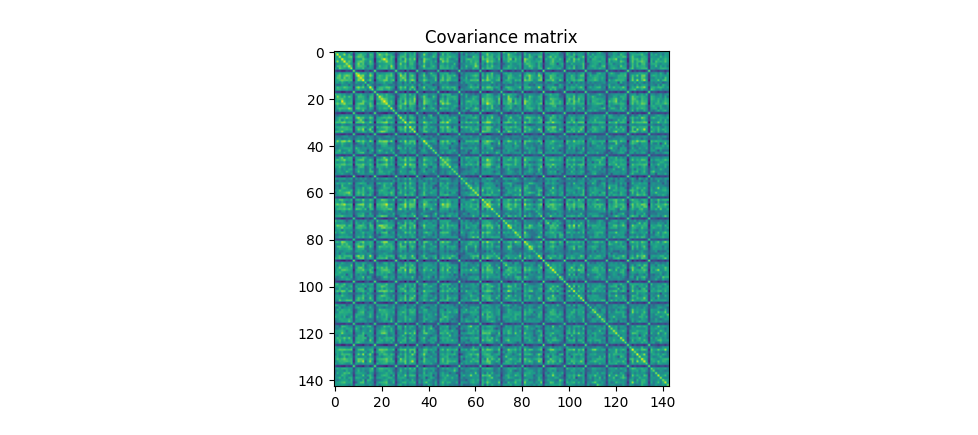

In [11]:
# That looks pretty good so far, but we also got some sort of separators or interconnects every 9th column

# They look pretty much the same, so we should be able to identify them based on for example
# a covariance matrix

# Calculate a covariance matrix based on our column candidates
cov_input = img_gray[:, col_label_com]
cov_matrix = numpy.cov(cov_input, rowvar=False)

plt.figure()
plt.imshow(cov_matrix)
plt.title('Covariance matrix')
plt.show()

In [12]:
# The separator columns are clearly identifiable in the covariance matrix

# Get the indices of all columns in the covariance matrix that sum up
# to negative values
cov_col_projection = numpy.sum(cov_matrix, axis=0)
separator_idx = numpy.nonzero(cov_col_projection<0)[0]

# Remove these indices from our column candidates
column_candidates = numpy.delete(col_label_com, separator_idx)

<IPython.core.display.Javascript object>


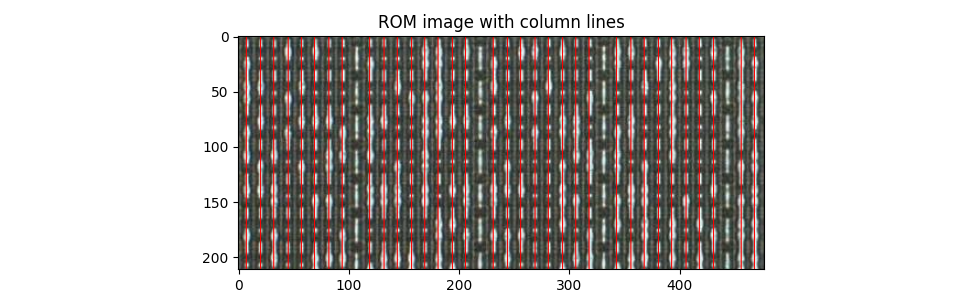

In [13]:
# Redraw the image with column lines
img_col_lines = numpy.copy(img)
img_col_lines[:,column_candidates] = (255,0,0)

plt.figure()
plt.imshow(img_col_lines)
plt.title('ROM image with column lines')
plt.show()

<IPython.core.display.Javascript object>


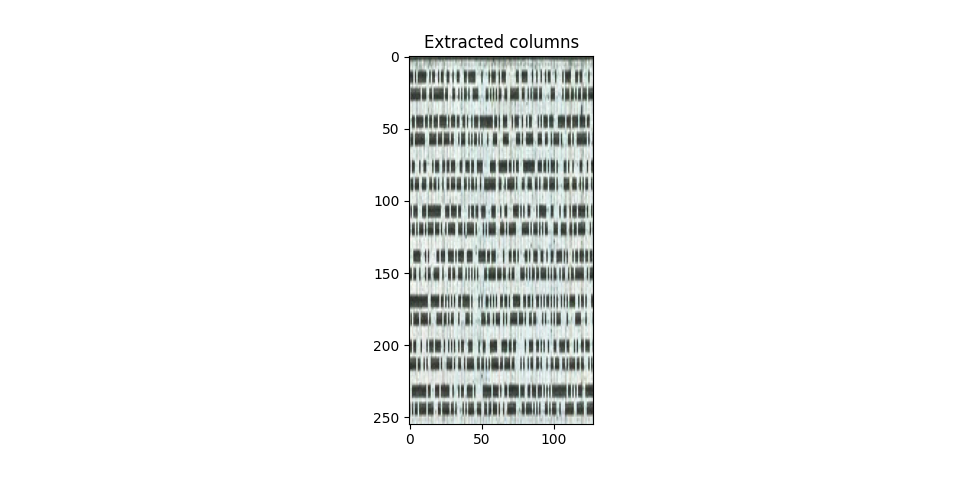

In [14]:
# The columns look better now.

# Before we have a look at the rows, let's see what the extracted columns look like.
# Let's just get all the versions, for later
extracted_columns = img[:,column_candidates]
gray_extracted_columns = img_gray[:,column_candidates]
binary_extracted_columns = img_binary[:,column_candidates]

plt.figure()
plt.imshow(extracted_columns)
plt.title('Extracted columns')
plt.show()

<IPython.core.display.Javascript object>


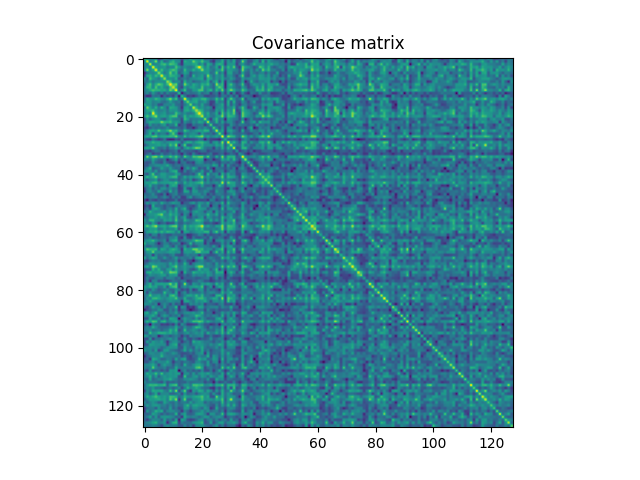

In [15]:
# Okay, so besides a line at the very top the data looks pretty good so far

# What does the covariance matrix look like now?
cov_matrix_after = numpy.cov(gray_extracted_columns, rowvar=False)

plt.figure()
plt.imshow(cov_matrix_after)
plt.title('Covariance matrix')
plt.show()

In [16]:
# Looking row-wise at the extracted columns above,
# we see that the interesting rows contain lots of alternating light and dark.

# An easy way to find those sections is to calculate the discrete differences
# along the rows.

# Let's work on the binary version for better contrast

diffed_rows = numpy.diff(binary_extracted_columns)

# Calculate the row projections
diffed_rows_sum = numpy.sum(diffed_rows, axis=1)

# Filter the same way as we did for the columns
diffed_rows_sum_filtered = numpy.copy(diffed_rows_sum)
diffed_rows_sum_filtered[diffed_rows_sum<numpy.mean(diffed_rows_sum)] = 0

# Now run label and calculate the centers of mass
row_labels, row_num_features = ndimage.label(diffed_rows_sum_filtered)
row_label_slices = ndimage.find_objects(row_labels)

row_label_com = numpy.array(
    [int(s.start + ndimage.measurements.center_of_mass(diffed_rows_sum_filtered[s.start:s.stop])[0])
    for row_label_slice in row_label_slices for s in row_label_slice])

<IPython.core.display.Javascript object>


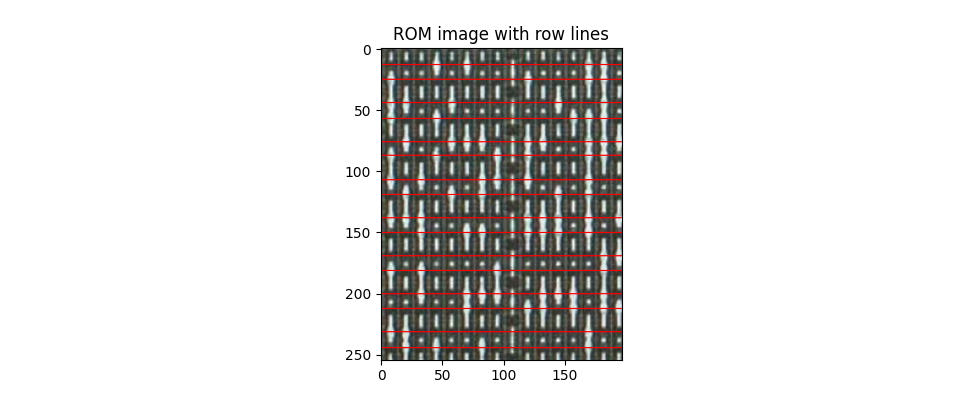

In [17]:
# Draw the row lines to see what we have
img_row_lines = numpy.copy(img)
img_row_lines[row_label_com,:] = (255,0,0)

plt.figure()
plt.imshow(img_row_lines)
plt.title('ROM image with row lines')
plt.show()

<IPython.core.display.Javascript object>


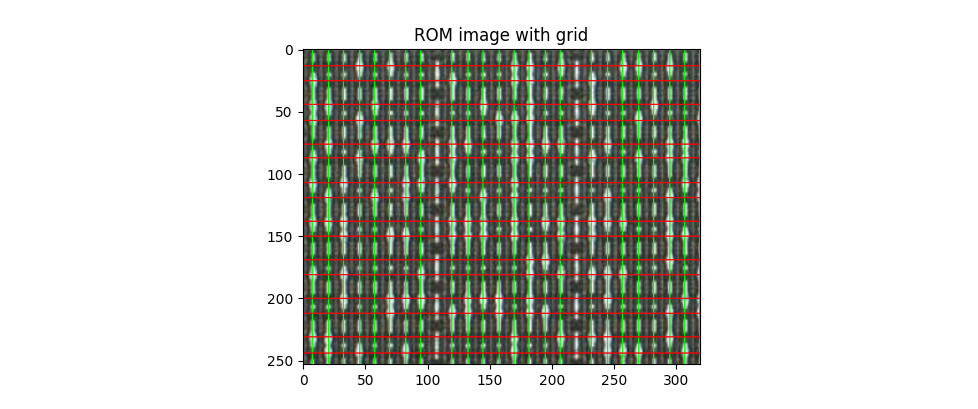

In [18]:
# That looks pretty decent, so no need to get fancy with covariance matrices here
# Next, let's do both columns and rows at the same time

img_grid = numpy.copy(img)
img_grid[:,column_candidates] = (0,255,0)
img_grid[row_label_com,:] = (255,0,0)

plt.figure()
plt.imshow(img_grid)
plt.title('ROM image with grid')
plt.show()

<IPython.core.display.Javascript object>


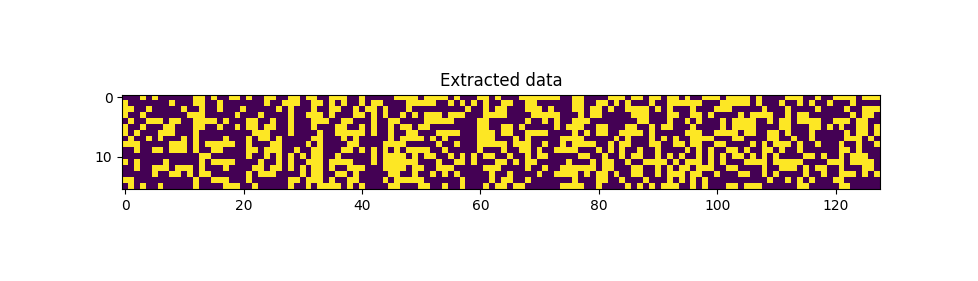

In [19]:
# Extract the intersections
extracted_data = numpy.copy(img_binary)
extracted_data = extracted_data[:,column_candidates]
extracted_data = extracted_data[row_label_com,:]

extracted_data[extracted_data==255] = 1

plt.figure()
plt.imshow(extracted_data)
plt.title('Extracted data')
plt.show()

In [20]:
# Save the extracted bits as ones and zeros in a text file for further processing
numpy.savetxt('dmg-cpu-c_rom_extracted.txt', extracted_data, fmt='%d', delimiter='')